In [8]:
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from bayes_opt import BayesianOptimization
import xgboost

import seaborn as sns; sns.set_theme(color_codes=True)
import pandas as pd
import numpy as np

from datetime import datetime
import pickle
import json
import glob
import os

In [9]:
# point these at the training and validation csv files
training_data_path = os.path.join(os.getcwd(),'data/dam forecast train.csv')

val_data_path = os.path.join(os.getcwd(),'data/dam forecast val.csv')

In [10]:
# set location to save model
model_folder = os.getcwd()
model_name = 'dam_forecast_10-10-22.pkl'
model_path = os.path.join(model_folder,'data',model_name)
model_path

'/home/nick/Documents/Work code/Dam-Forecast/data/dam_forecast_10-10-22.pkl'

In [11]:
# we limit the max dam size as large dams are note well represented in our dataset 
max_value = 20000

In [12]:
# load up training data, do some cleaning
training_data = pd.read_csv(training_data_path)
training_data = training_data.reindex(sorted(training_data.columns), axis=1)
training_data = (training_data[training_data['area'] < max_value])
training_data

,SRC_DATE,acq_date_dec,acq_month,acq_year,area,area_2,class,class_name,file_name,geometry,...,tavg_12_months before,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before
0,20191216,2019.923077,12,2019,1499.986376,0.000000,2,no water,arcgisonline_13466_pred_and_score.tif,POINT (150.7703260923624 -34.49997476956882),...,22.234226,20.396746,17.926054,15.415278,12.961130,13.086934,13.189901,16.016296,18.968658,21.853695
1,20191216,2019.923077,12,2019,1957.925202,0.000000,2,no water,arcgisonline_19956_pred_and_score.tif,POINT (150.7609417292462 -34.5194085769909),...,22.165726,20.336300,17.855085,15.332343,12.882524,13.011043,13.112334,15.936459,18.891691,21.774044
2,20191216,2019.923077,12,2019,56.557682,0.000000,2,no water,arcgisonline_29686_pred_and_score.tif,POINT (150.7921407085229 -34.48640159069117),...,22.226084,20.390297,17.952702,15.478308,13.054444,13.186954,13.291353,16.112299,19.028639,21.890549
3,20191216,2019.923077,12,2019,620.839041,69.919793,0,dam and water,arcgisonline_2208_pred_and_score.tif,POINT (150.8273026231211 -34.59007854166663),...,21.477997,19.747135,17.428568,15.065031,12.862777,13.064048,13.170877,15.932156,18.648500,21.329342
4,20191216,2019.923077,12,2019,911.591665,85.853539,0,dam and water,arcgisonline_43254_pred_and_score.tif,POINT (150.8025877887565 -34.57963568981891),...,21.803089,20.026794,17.639698,15.219195,12.937696,13.106893,13.211027,16.005402,18.805094,21.575476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122355,20110314,2011.230769,3,2011,4690.590130,3356.800411,0,dam and water,arcgisonline_72191_pred_and_score.tif,POINT (143.373276551677 -36.86267870873694),...,19.154816,20.478308,21.291294,18.070200,16.456215,13.273601,10.126436,8.112340,7.877004,8.320145
122356,20110314,2011.230769,3,2011,4209.619407,3706.714804,0,dam and water,arcgisonline_71743_pred_and_score.tif,POINT (143.3411322554059 -36.57633393114442),...,19.665329,21.165747,22.008965,18.720106,17.090002,13.734396,10.366534,8.349343,8.038947,8.630186
122357,20110314,2011.230769,3,2011,5667.357300,4151.021853,0,dam and water,arcgisonline_72120_pred_and_score.tif,POINT (143.372506189926 -36.89085348297849),...,19.164637,20.472593,21.282869,18.080053,16.459044,13.295247,10.181856,8.173169,7.926465,8.359044
122358,20110314,2011.230769,3,2011,5681.396963,4562.555806,0,dam and water,arcgisonline_72047_pred_and_score.tif,POINT (143.4424332013378 -36.69242942639055),...,19.555471,20.999870,21.831772,18.576399,16.969004,13.661123,10.368485,8.374519,8.058324,8.584326


In [14]:
t_names = []
r_names = []
for col_name in training_data.columns:
    if  'tavg' in col_name:
        t_names.append(col_name)
    if 'rain' in col_name:
        r_names.append(col_name)
t_names

['tavg_0_months before',
 'tavg_10_months before',
 'tavg_11_months before',
 'tavg_12_months before',
 'tavg_1_months before',
 'tavg_2_months before',
 'tavg_3_months before',
 'tavg_4_months before',
 'tavg_5_months before',
 'tavg_6_months before',
 'tavg_7_months before',
 'tavg_8_months before',
 'tavg_9_months before']

In [15]:
# load up validation data and to some sorting
val_data = pd.read_csv(val_data_path)
val_data = val_data.reindex(sorted(val_data.columns), axis=1)
val_data = (val_data[val_data['area'] < max_value])

val_data.head()

,SRC_DATE,acq_date_dec,acq_month,acq_year,area,area_2,class,class_name,file_name,geometry,...,tavg_12_months before,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before
0,20151012,2015.769231,10,2015,1467.191148,400.256079,0,dam and water,arcgisonline_132898_pred_and_score.tif,POINT (117.3172965191077 -33.24564247144878),...,16.436865,12.835136,11.108263,10.531229,12.044368,12.067635,16.236391,20.395378,24.588543,23.805340
1,20160808,2016.615385,8,2016,7575.018970,5781.220903,0,dam and water,arcgisonline_70618_pred_and_score.tif,POINT (152.9625759629707 -26.43549796464562),...,16.606274,16.208225,16.421938,19.850100,22.161938,24.166159,25.166771,24.075779,23.361519,23.210749
2,20150329,2015.230769,3,2015,2028.126533,581.212166,0,dam and water,arcgisonline_84979_pred_and_score.tif,POINT (142.9804044837108 -37.77391478774938),...,17.330566,20.310444,18.668152,16.997301,15.661266,13.949310,11.053338,8.662997,8.203583,9.625609
3,20151215,2015.923077,12,2015,569.161178,317.463008,0,dam and water,arcgisonline_101081_pred_and_score.tif,POINT (145.618767566165 -38.4325091507143),...,17.489389,15.805417,15.925524,11.613432,9.590775,9.022965,10.216203,12.452333,14.021166,16.439243
4,20160416,2016.307692,4,2016,3367.296500,508.559500,0,dam and water,arcgisonline_125002_pred_and_score.tif,POINT (118.0078021793126 -30.57147183423009),...,18.163313,24.274788,26.393480,26.532434,24.433882,23.749607,21.477095,14.928035,12.299461,11.371953


In [16]:
# remove val data from training data
val_file_names = val_data['file_name'].to_list()

training_data = training_data[~training_data.file_name.isin(val_file_names)]

In [17]:
training_data

,SRC_DATE,acq_date_dec,acq_month,acq_year,area,area_2,class,class_name,file_name,geometry,...,tavg_12_months before,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before
0,20191216,2019.923077,12,2019,1499.986376,0.000000,2,no water,arcgisonline_13466_pred_and_score.tif,POINT (150.7703260923624 -34.49997476956882),...,22.234226,20.396746,17.926054,15.415278,12.961130,13.086934,13.189901,16.016296,18.968658,21.853695
1,20191216,2019.923077,12,2019,1957.925202,0.000000,2,no water,arcgisonline_19956_pred_and_score.tif,POINT (150.7609417292462 -34.5194085769909),...,22.165726,20.336300,17.855085,15.332343,12.882524,13.011043,13.112334,15.936459,18.891691,21.774044
2,20191216,2019.923077,12,2019,56.557682,0.000000,2,no water,arcgisonline_29686_pred_and_score.tif,POINT (150.7921407085229 -34.48640159069117),...,22.226084,20.390297,17.952702,15.478308,13.054444,13.186954,13.291353,16.112299,19.028639,21.890549
3,20191216,2019.923077,12,2019,620.839041,69.919793,0,dam and water,arcgisonline_2208_pred_and_score.tif,POINT (150.8273026231211 -34.59007854166663),...,21.477997,19.747135,17.428568,15.065031,12.862777,13.064048,13.170877,15.932156,18.648500,21.329342
4,20191216,2019.923077,12,2019,911.591665,85.853539,0,dam and water,arcgisonline_43254_pred_and_score.tif,POINT (150.8025877887565 -34.57963568981891),...,21.803089,20.026794,17.639698,15.219195,12.937696,13.106893,13.211027,16.005402,18.805094,21.575476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122355,20110314,2011.230769,3,2011,4690.590130,3356.800411,0,dam and water,arcgisonline_72191_pred_and_score.tif,POINT (143.373276551677 -36.86267870873694),...,19.154816,20.478308,21.291294,18.070200,16.456215,13.273601,10.126436,8.112340,7.877004,8.320145
122356,20110314,2011.230769,3,2011,4209.619407,3706.714804,0,dam and water,arcgisonline_71743_pred_and_score.tif,POINT (143.3411322554059 -36.57633393114442),...,19.665329,21.165747,22.008965,18.720106,17.090002,13.734396,10.366534,8.349343,8.038947,8.630186
122357,20110314,2011.230769,3,2011,5667.357300,4151.021853,0,dam and water,arcgisonline_72120_pred_and_score.tif,POINT (143.372506189926 -36.89085348297849),...,19.164637,20.472593,21.282869,18.080053,16.459044,13.295247,10.181856,8.173169,7.926465,8.359044
122358,20110314,2011.230769,3,2011,5681.396963,4562.555806,0,dam and water,arcgisonline_72047_pred_and_score.tif,POINT (143.4424332013378 -36.69242942639055),...,19.555471,20.999870,21.831772,18.576399,16.969004,13.661123,10.368485,8.374519,8.058324,8.584326


In [18]:
# view all training data columns
training_data.columns

Index(['SRC_DATE', 'acq_date_dec', 'acq_month', 'acq_year', 'area', 'area_2',
       'class', 'class_name', 'file_name', 'geometry', 'rain_0_months before',
       'rain_10_months before', 'rain_11_months before',
       'rain_12_months before', 'rain_1_months before', 'rain_2_months before',
       'rain_3_months before', 'rain_4_months before', 'rain_5_months before',
       'rain_6_months before', 'rain_7_months before', 'rain_8_months before',
       'rain_9_months before', 'tavg_0_months before', 'tavg_10_months before',
       'tavg_11_months before', 'tavg_12_months before',
       'tavg_1_months before', 'tavg_2_months before', 'tavg_3_months before',
       'tavg_4_months before', 'tavg_5_months before', 'tavg_6_months before',
       'tavg_7_months before', 'tavg_8_months before', 'tavg_9_months before'],
      dtype='object')

In [19]:
# set a list of columns to drop, the model will not see these
drop_list = ['area_2','file_name', 'SRC_DATE','geometry','acq_year','acq_month','acq_date_dec','class','class_name']

In [20]:
# remove the drop list and setup target df
train_X = training_data.drop(columns=drop_list)
train_y = training_data[['area_2']]
print(train_y.head())
train_X.head()

      area_2
0   0.000000
1   0.000000
2   0.000000
3  69.919793
4  85.853539


,area,rain_0_months before,rain_10_months before,rain_11_months before,rain_12_months before,rain_1_months before,rain_2_months before,rain_3_months before,rain_4_months before,rain_5_months before,...,tavg_12_months before,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before
0,1499.986376,2.762451,36.125671,71.728584,69.268257,18.543798,32.006516,61.439262,35.894455,16.539648,...,22.234226,20.396746,17.926054,15.415278,12.961130,13.086934,13.189901,16.016296,18.968658,21.853695
1,1957.925202,3.197464,38.361225,75.389587,73.195740,19.394297,34.531719,64.828262,38.369305,17.053242,...,22.165726,20.336300,17.855085,15.332343,12.882524,13.011043,13.112334,15.936459,18.891691,21.774044
2,56.557682,2.658848,35.916077,69.969917,66.735779,18.249218,31.475410,60.696507,35.672646,16.840359,...,22.226084,20.390297,17.952702,15.478308,13.054444,13.186954,13.291353,16.112299,19.028639,21.890549
3,620.839041,4.103868,46.451984,76.181908,72.046654,19.497202,38.455097,70.509048,42.860733,19.531702,...,21.477997,19.747135,17.428568,15.065031,12.862777,13.064048,13.170877,15.932156,18.648500,21.329342
4,911.591665,3.889048,44.183247,76.219666,72.164078,19.490854,37.583042,69.094116,42.032280,18.774553,...,21.803089,20.026794,17.639698,15.219195,12.937696,13.106893,13.211027,16.005402,18.805094,21.575476


In [21]:
# setup validation sets
val_X = val_data.drop(columns=drop_list)
val_y = val_data[['area_2']].copy()
print(train_y.head())
print(train_X.shape)
train_X.head()

      area_2
0   0.000000
1   0.000000
2   0.000000
3  69.919793
4  85.853539
(108847, 27)


,area,rain_0_months before,rain_10_months before,rain_11_months before,rain_12_months before,rain_1_months before,rain_2_months before,rain_3_months before,rain_4_months before,rain_5_months before,...,tavg_12_months before,tavg_1_months before,tavg_2_months before,tavg_3_months before,tavg_4_months before,tavg_5_months before,tavg_6_months before,tavg_7_months before,tavg_8_months before,tavg_9_months before
0,1499.986376,2.762451,36.125671,71.728584,69.268257,18.543798,32.006516,61.439262,35.894455,16.539648,...,22.234226,20.396746,17.926054,15.415278,12.961130,13.086934,13.189901,16.016296,18.968658,21.853695
1,1957.925202,3.197464,38.361225,75.389587,73.195740,19.394297,34.531719,64.828262,38.369305,17.053242,...,22.165726,20.336300,17.855085,15.332343,12.882524,13.011043,13.112334,15.936459,18.891691,21.774044
2,56.557682,2.658848,35.916077,69.969917,66.735779,18.249218,31.475410,60.696507,35.672646,16.840359,...,22.226084,20.390297,17.952702,15.478308,13.054444,13.186954,13.291353,16.112299,19.028639,21.890549
3,620.839041,4.103868,46.451984,76.181908,72.046654,19.497202,38.455097,70.509048,42.860733,19.531702,...,21.477997,19.747135,17.428568,15.065031,12.862777,13.064048,13.170877,15.932156,18.648500,21.329342
4,911.591665,3.889048,44.183247,76.219666,72.164078,19.490854,37.583042,69.094116,42.032280,18.774553,...,21.803089,20.026794,17.639698,15.219195,12.937696,13.106893,13.211027,16.005402,18.805094,21.575476


In [22]:
# save out metadata to json, this is usefull when running predictions
meta_dict = {'col_names':list(train_X.columns),
            'model_path':model_path,
            'creation_date':str(datetime.today().strftime('%Y-%m-%d'))}

with open(model_path.replace('.pkl','.json'), 'w') as fp:
    json.dump(meta_dict, fp)

In [23]:
model_path

'/home/nick/Documents/Work code/Dam-Forecast/data/dam_forecast_10-10-22.pkl'

In [24]:
def train_model(learning_rate,n_estimators,max_depth,min_split_loss,min_child_weight,max_delta_step,subsample):

    n_estimators = round(n_estimators)
    max_depth = round(max_depth)
    xgb_reg = XGBRegressor(learning_rate = learning_rate, 
                               n_estimators = n_estimators,
                               max_depth=max_depth,
                               tree_method='hist',
                              )
    
    xgb_reg.fit(train_X, train_y, eval_set=[(train_X, train_y)],verbose = 0)

    y_pred = xgb_reg.predict(val_X)
    y_pred = y_pred*(y_pred>0)
    
    model_mean_error = mean_absolute_error(val_data['area_2'].to_numpy(), y_pred)
            
    return(-model_mean_error)

In [25]:
pbounds = {'learning_rate': (0.1, 0.5), 'n_estimators': (10, 700),'max_depth': (1,15),
          'min_split_loss': (0,1),'min_child_weight': (0,2),'max_delta_step': (0,10),
          'subsample': (0,1)}

In [26]:
optimizer = BayesianOptimization(
    f=train_model,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

In [27]:
optimizer.maximize(
    init_points=5,
    n_iter=10,
)

|   iter    |  target   | learni... | max_de... | max_depth | min_ch... | min_sp... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -397.5    |  0.2668   |  7.203    |  1.002    |  0.6047   |  0.1468   |  73.71    |  0.1863   |
|  2        | -345.7    |  0.2382   |  3.968    |  8.543    |  0.8384   |  0.6852   |  151.1    |  0.8781   |
|  3        | -339.4    |  0.111    |  6.705    |  6.842    |  1.117    |  0.1404   |  146.7    |  0.8007   |
|  4        | -359.0    |  0.4873   |  3.134    |  10.69    |  1.753    |  0.8946   |  68.68    |  0.03905  |
|  5        | -357.8    |  0.1679   |  8.781    |  2.377    |  0.8422   |  0.9579   |  377.9    |  0.6919   |
|  6        | -371.3    |  0.4176   |  2.371    |  12.59    |  0.8155   |  0.9076   |  139.0    |  0.9621   |
|  7        | -357.2    |  0.1      |  9.862    |  2.907    |  1.35     |  0.0      |  151.1    |  0.6872   |
|  8      

In [28]:
best_pers = optimizer.max
best_pers

{'target': -339.39183104649,
 'params': {'learning_rate': 0.11095503727917047,
  'max_delta_step': 6.704675101784022,
  'max_depth': 6.842267233139777,
  'min_child_weight': 1.1173796568915033,
  'min_split_loss': 0.14038693859523377,
  'n_estimators': 146.69002746856637,
  'subsample': 0.8007445686755367}}

In [29]:
def train_fin_model(learning_rate,n_estimators,max_depth,min_split_loss,min_child_weight,max_delta_step,subsample):

    n_estimators = round(n_estimators)
    max_depth = round(max_depth)
    xgb_reg = XGBRegressor(learning_rate = learning_rate, 
                               n_estimators = n_estimators,
                               max_depth=max_depth,                        
                               tree_method='hist',            
                              )
    xgb_reg.fit(train_X, train_y, eval_set=[(train_X, train_y)],verbose = 0)
    
    return(xgb_reg)

In [30]:
xgb_reg = train_fin_model(**best_pers['params'])

In [31]:
# run prediction on validation set
y_pred = xgb_reg.predict(val_X)
y_pred = y_pred*(y_pred>0)
val_y['preds'] = [value for value in y_pred]

[(0.0, 20000.0)]

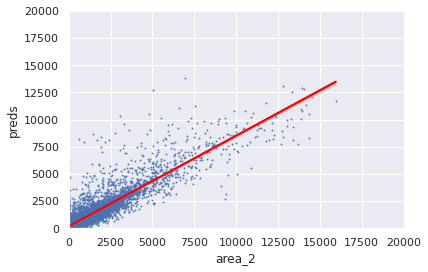

In [32]:
# plot up validation data preds vs measured values
ax = sns.regplot(x="area_2", y="preds", data=val_y,
                 scatter_kws={'s':1},
                 line_kws={"color": "red"})

ax.set(ylim=(0, max_value))
ax.set(xlim=(0, max_value))

In [33]:
# use numpy to calc the line of best fit equation
np.polyfit(val_y['area_2'], val_y['preds'], 1)

array([  0.83357599, 177.64792309])

In [34]:
# calc the model error and abs error 
val_y['error'] = val_y['preds']-val_data['area_2']
val_y['abs_error'] = abs(val_y['error'])
val_y.head()

,area_2,preds,error,abs_error
0,400.256079,285.564545,-114.691534,114.691534
1,5781.220903,4204.354980,-1576.865922,1576.865922
2,581.212166,640.824646,59.612480,59.612480
3,317.463008,234.865799,-82.597209,82.597209
4,508.559500,962.868774,454.309275,454.309275


In [35]:
# calc the mean abs model error
model_mean_error = val_y['abs_error'].mean()
model_mean_error

339.39183104648816

In [36]:
# we can now compare the model to if we had just predicted the mean values for each row
# calc the overall mean from the measured values
mean_value = val_y['area_2'].mean()
# calc the abs distance each row is from the mean
val_y['dist_from_mean'] = abs(val_y['area_2']-mean_value)
# calc the mean distance from the mean, this is comparable to the model_mean_error value above
mean_dist_from_mean = val_y['dist_from_mean'].mean()
mean_dist_from_mean

885.8515476619473

In [37]:
# we can now compare the model_mean_error with the mean_dist_from_mean
'The model is explaining '+f"{1-model_mean_error/mean_dist_from_mean:.0%}" +' of the variance'

'The model is explaining 62% of the variance'

In [38]:
# save model to disk
pickle.dump(xgb_reg, open(model_path, "wb"))

In [39]:
model_path

'/home/nick/Documents/Work code/Dam-Forecast/data/dam_forecast_10-10-22.pkl'